In [1]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import cv2
import fractions
import math
from matplotlib import image
import random
from skimage import morphology,feature
#from tensorflow.keras.preprocessing.image import ImageDataGenerator

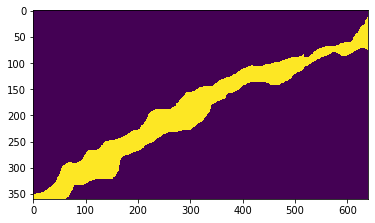

In [2]:
directory ="C:\\Users\\limeh\\Downloads\\DiscreteSkeletonEvolution\\DSE\\crack_test.png"
img = image.imread(directory)
#img = morphology.medial_axis(img)
plt.figure()
plt.imshow(img)

# Import images from Crack500 dataset


In [3]:
# Specify text file directory
def generator_data(directory_text,directory_image,num_data,dims,interpolation):
    """
    This function returns the file name of the input label and corresponding ground truth
    Arguments:
    directory - Provide the directory to read a file
    """
    input_data = None
    ground_truth = None
    with open(directory_text,"r") as f:
        data = f.readlines()
    
    random.shuffle(data)
    data_list = []
    i = 0
    while True:
        try:
            input_data = data[i].split()[0]
            ground_truth = data[i].split()[1]
            data_list.append([input_data,ground_truth])
            i = i + 1
            if i == num_data:
                data_array = image_data(directory_image,data_list,dims,interpolation)
                yield data_array
                data_list = []
        except IndexError as e:
            data_array = image_data(directory_image,data_list,dims,interpolation)
            yield data_array
            break


In [4]:
def image_data(directory,data_list,dims,interpolation):
    """
    This function obtains data_list from get_train_data_names and then 
    converts the image into a square image.
    
    Arguments:
    data_list - list of data names and corresponding ground truth
    dims - Resize image to user input size, required to be a tuple
    
    Return:
    data_array - Returns the image as a numpy array
    """
    
    data_array = []
    for i in range(len(data_list)):
        x = cv2.imread(directory + data_list[i][0],cv2.IMREAD_GRAYSCALE)
        y = cv2.imread(directory + data_list[i][1],cv2.IMREAD_UNCHANGED)
        
        x = cv2.resize(x,dims,interpolation = interpolation)/255
        y = cv2.resize(y,dims,interpolation = interpolation)/255
        
        data_array.append([x,y])
        
    return data_array

In [5]:
def get_data(gen):
    #try:
    data = next(gen)
    for i in range(len(data)):
        data[i][0] = np.pad(data[i][0],((1,1),(1,1)),"constant")
        data[i][1] = np.pad(data[i][1],((1,1),(1,1)),"constant")
    return data
    #except:
    #    return -1


In [6]:
directory_text = "./Data/CRACK500/train.txt"
directory_image = "./Data/CRACK500/traincrop/"
x_train = generator_data(directory_text,directory_image,20,(160,90),interpolation = cv2.INTER_CUBIC)

directory_text = "./Data/CRACK500/val.txt"
directory_image = "./Data/CRACK500/valcrop/"
x_test = generator_data(directory_text,directory_image,10,(64,64),interpolation = cv2.INTER_CUBIC)
x_train_data = get_data(x_train)
x_test_data = get_data(x_test)

In [7]:
print(x_train_data[1][0].shape)

(92, 162)


In [8]:
print(x_train_data[1][1].shape)

(92, 162)


# Skeletonize binary images

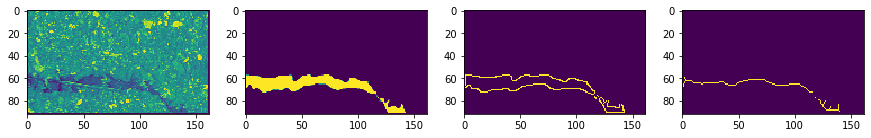

In [9]:
index = 5
fig, ax = plt.subplots(nrows = 1, ncols = 4,figsize = (15,15))

img_bnr = x_train_data[index][1]
#img_bnr = morphology.binary_opening(x_train_data[index][1])
#img_bnr = morphology.binary_closing(img_bnr)

edge = feature.canny(img_bnr)
skl_image = morphology.medial_axis(img_bnr)
skl_image2 = morphology.skeletonize(img_bnr)

ax[0].imshow(x_train_data[index][0])
ax[1].imshow(x_train_data[index][1])
ax[2].imshow(edge)
ax[3].imshow(skl_image2)

# Tangent of curve

In [10]:
def get_skel_points(img,cropped = True):
    """
    This function obtains positive cracks from the given image.

    Arguments:
    img - The input image
    
    Return:
    x - x coordinates
    y - y coordinates
    
    """
    
    (y,x) = np.nonzero(img) # Returns a tuple of array ([y],[x])
    
    # True only if coordinate shifting, False if using global coordinates
    if cropped:
        # Coordinate shifting to have center at (0,0) and flip the y-axis
        y = -1*(y - 1) # Flips the y axis
        x = x - 1        
    
    return x,y

In [11]:
def get_dydx(cropped_img,linspace = 51):
    """
    This function gets a 3x3 cropped image to and approximates the 
    crack points as a polynomial. The x and y values are placed on
    a grid as shown:
    
    [[(-1,1),(0,1),(1,1)],
    [(-1,0),(0,0),(1,0)],
    [(-1,-1),(0,-1),(1,-1)]]
    
    The point of interest is only at the gradient at point (0,0)
    
    Arguments:
    x - x coordinates
    y - y coordinates
    space = space for linspace
    """
    
    # Check if there is only 1 pixel in crack, then return early
    
    if np.sum(np.squeeze(cropped_img.flatten())) == 1:
        plt.figure()
        plt.imshow(cropped_img,extent = [-3/2.,3/2., -3/2.,3/2.])
        return 0, False
    # Obtain the x and y value of cropped image
    x,y = get_skel_points(cropped_img)
    #print(x,y)
    num_points = len(x)
    vert = False   
    # Checks if all values of y
    x_check = [-1,0,1]
    
    # Check for possible vertical 
    for x_val in x_check:
        occurences = np.count_nonzero(x == x_val)
        if occurences >= 2 and num_points <= 3 :
            #print(occurences)
            vert = True
            break          
    
    p_deg = (num_points - 1) if num_points > 1 else 1
    linspace = (linspace + 1) if linspace % 2 == 0 else linspace
    x_new = np.linspace(-1,1,num = linspace)
    
    
    #print(x_new)
    if vert == False:
        plt.figure()
        plt.imshow(cropped_img,extent = [-3/2.,3/2., -3/2.,3/2.])
        weights = np.polyfit(x,y,p_deg)
        fx = np.poly1d(weights)
    else:
        plt.figure()
        plt.imshow(cropped_img,extent = [-3/2.,3/2., -3/2.,3/2.])
        cropped_img = np.rot90(cropped_img) # Rotate the image anticlockwise 90 degrees
        x,y = get_skel_points(cropped_img) # Update the x,y coordinates
        weights = np.polyfit(x,y,p_deg)
        fx = np.poly1d(weights)        
    
    y_new = fx(x_new)
    x0_pos = np.where(x_new == 0)
    #print(y_new)
    dy = np.gradient(y_new,2/(linspace-1))
    #print(dy)
    #print(x0_pos)
    dy0 = str(dy[x0_pos])[1:-1] # dy when x = 0 stored in string format
    
    dy = fractions.Fraction(dy0).limit_denominator()
    
    plt.figure()
    plt.imshow(cropped_img,extent = [-3/2.,3/2., -3/2.,3/2.])
    plt.plot(x,y,"bo")
    plt.plot(x_new,fx(x_new))
    plt.show()
    return dy,vert

In [12]:
def get_cropped(img,x,y):
    """
    This function returns 3x3 cropped images at every 
    skeleton point
    
    Arguments:
    img - the skeleton image
    x - x global coordinate of the skeleton
    y - y global coordinate of the skeleton
    """
     
    (row,column) = np.meshgrid(np.array([x-1,x,x+1]), np.array([y-1,y,y+1]))
    row = row.astype('int')
    column= column.astype('int')
    
    cropped_img = img[column,row]
    
    return cropped_img

# Get end points and intersection points

In [13]:
def get_imp_points(img):

    end_points = []
    inter_points = []
    #img = np.pad(img,((1,1),(1,1)),"constant")
    (rows,cols) = np.nonzero(img)
    
    for (r,c) in zip(rows,cols):

        if np.sum(img[r-1:r+2,c-1:c+2]) == 2:
#             plt.figure()
#             plt.imshow(img[row_n,col_n])
            end_points.append((c,r))
        elif np.sum(img[r-1:r+2,c-1:c+2]) > 3:
            inter_points.append((c,r))
     
    #     for point1 in t_inter_points:
    #         temp_x = [point1[0]]
    #         temp_y = [point1[1]]
    #         for point2 in t_inter_points:
    #             if ((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2 < 9**2) and (point1 != point2):
    #                 temp_x.append(point2[0])
    #                 temp_y.append(point2[1])

    #         x_avg = int(math.floor(sum(temp_x)/len(temp_x)))
    #         y_avg = int(math.floor(sum(temp_y)/len(temp_y)))

    #         inter_points.append((x_avg,y_avg))  

    #     #all_branch = get_branches(img)
    #     end_points = list(set(end_points))
    #     inter_points = list(set(inter_points))
    #     #num_branch = get_num_branch(all_branch,inter_points)
    
    return end_points, inter_points

In [14]:
def get_branches(img):
    """
    This algorithm gets the branches of the skeleton image from end points to
    intersection point. The determined branches are used for DSE pruning method.
    
    Branches from one intersection point to another intersection point is not considered
    because it is definitely important to the reconstruction of the binary image.
    
    i.e. Only end point to intersection point is considered. 
    
    Arguments:
    img - Skeletonized image
    
    Return
    all_branches - A list of lists of coordinates (x,y) of the branches
    """
   
    E,_ = get_imp_points(img)  
    all_branches = []
    print(f"The end points: {E}")
    for e in E:
        branch = []
        r_g, c_g = e[1], e[0]
        branch.append((c_g,r_g))

        while np.sum(img[r_g-1:r_g+2,c_g-1:c_g+2]) <= 3:
            (r_t,c_t) = np.nonzero(img[r_g-1:r_g+2,c_g-1:c_g+2])
            r_t = r_t-1+r_g
            c_t = c_t-1+c_g
            for point in zip(c_t,r_t):
                if point not in branch:
                    branch.append(point)

            r_g = branch[-1][1]
            c_g = branch[-1][0]
            if (c_g,r_g) in E:
                branch.append((c_g,r_g))
                break
        all_branches.append(branch)  
        
    return all_branches      

In [15]:
def get_num_branch(all_branches,inter_points):
    
    list_num_branch = []
    for point in inter_points:
        num_branch = 0
        for branch in all_branches:
            if point in branch:
                all_branches.remove(branch)
                num_branch += 1
        list_num_branch.append(num_branch)
        
    return list_num_branch
                

# Discrete Skeletonization Evolution Algorithm

In [16]:
def reconstruct(skel_img,dist_tr):
    """
    Attempt to reconstruct the binary image from the skeleton
    
    Arguments:
    img - Skeleton image using thinning algorithm
    dist_tr - Distance transform matrix
    
    Return:
    bn_img - Binary image
    """
    row, col = np.nonzero(skel_img)
    bn_img = skel_img.copy()*1
    for (r,c) in zip(row,col):
        radius = math.ceil(dist_tr[r,c]-1)
        if radius >= 1:
            stel = morphology.disk(radius)
            bn_img[r-radius:r+radius+1,c-radius:c+radius+1] += stel
    
    return bn_img >= 1

In [17]:

def DSE_v1(img,threshold):
    """
    Discrete Skeletonization Evolution algorithm
    Prunes spurious branches obtained from medial axis transform.
    
    Arguments:
    img - Binary image
    
    Returns:
    pruned_img - Pruned binary image using DSE
    """

    _,dist = morphology.medial_axis(img,return_distance = True) 
    skel_img = morphology.thin(img)
    skel_img = morphology.closing(skel_img)
    ori_img = img.copy()
    all_branches = get_branches(skel_img)
    iou = lambda ori_img,img2: np.sum(ori_img*img2)/np.sum((ori_img+img2)>=1)

    iou_scores = []
    for branch in all_branches:
        skel_removed = skel_img.copy() # Initialization
        r = [i[1] for i in branch]
        c = [i[0] for i in branch]
        skel_removed[r,c] = 0

        bn_removed = reconstruct(skel_removed,dist) # Reconstruct the binary image without the branch 
        iou_scores.append(iou(ori_img,bn_removed))
        
    for score in reversed(sorted(iou_scores)):
        idx = iou_scores.index(score)
        
        if score > threshold:
            for points in all_branches[idx]:
                r,c = points[1], points[0]
                skel_img[r,c] = 0
        else:
            return skel_img, reconstruct(skel_img,dist)
        
    return morphology.closing(skel_img), reconstruct(skel_img,dist)

In [18]:
def DSE_v2(img,threshold):
    """
    Discrete Skeletonization Evolution algorithm
    Prunes spurious branches obtained from medial axis transform.
    
    Arguments:
    img - Binary image
    
    Returns:
    pruned_img - Pruned binary image using DSE
    """

    _,dist = morphology.medial_axis(img,return_distance = True) 
    skel_img = morphology.thin(img)
    skel_img = morphology.closing(skel_img)
    all_branches = get_branches(skel_img)
    iou = lambda ori_img,img2: np.sum(ori_img*img2)/np.sum((ori_img+img2)>=1)

    while True:
        
        iou_scores = []
        
        for branch in all_branches:
            skel_removed = skel_img.copy() # Initialization
            r = [i[1] for i in branch]
            c = [i[0] for i in branch]
            skel_removed[r,c] = 0
            bn_removed = reconstruct(skel_removed,dist)
            iou_scores.append(iou(img,bn_removed))
            
        if len(iou_scores)>0:
            max_score = max(iou_scores)
            if max_score > threshold:
                idx = iou_scores.index(max_score)

                for points in all_branches[idx]:
                    r,c = points[1], points[0]
                    skel_img[r,c] = 0
                del all_branches[idx]

            else:
                return skel_img, reconstruct(skel_img,dist)
        else:
            return skel_img, reconstruct(skel_img,dist)

  



In [19]:
test1 = np.array([[1,2,3],[4,5,6],[7,8,9]])
test1[[0,1,2],[0,1,2]] = 0
print(test1)

[[0 2 3]
 [4 0 6]
 [7 8 0]]


In [20]:
def DSE_v3(img,beta):
    """
    Discrete Skeletonization Evolution algorithm which finds the trade 
    off between skeleton simplicity and reconstruction error.
    
    Arguments:
    img - Binary image
    
    Returns:
    pruned_img - Pruned binary image using DSE
    """    
    
    M,dist = morphology.medial_axis(img,return_distance = True)
    #M = morphology.skeletonize(img)
    S_all = [M]
    norm_dist = lambda s: np.log(np.sum(s)+1)
    norm_area = lambda s,d: (np.sum(d)-np.sum(reconstruct(s,dist)))/np.sum(d)
    
    all_branches = get_branches(M)
    print(f"Number of branches: {len(all_branches)}")
    avg_len = np.mean([len(branch) for branch in all_branches])
    M_len = norm_dist(M)
    alpha = beta * np.log(M_len/avg_len)
    scores = [alpha*norm_area(M,reconstruct(M,dist))+norm_dist(M)]
    
    while len(all_branches) > 2:
        weights = []
        for branch in all_branches:
            S = M.copy()                  # S_(i) 
            r = [i[1] for i in branch]
            c = [i[0] for i in branch]

            S[r,c] = 0                    # Initialize the weights
            AR = norm_area(img,reconstruct(S,dist))
            LR = norm_dist(S)
            weights.append(alpha * AR + LR)

        min_idx = np.argmin(weights)
        E = all_branches[min_idx]         # The minimum branch to be removed 
        r = [i[1] for i in E]             # Get the rows of minimum weight branch
        c = [i[0] for i in E]             # Get the columns of minimum weight branch
#         print(f"Before: {np.sum(M)}")
        M[r,c] = 0                        # Remove the minimum branch from the medial axis, S_(i+1)
#         print(f"After: {np.sum(M)}")
        AR = norm_area(img,reconstruct(M,dist))
        LR = norm_dist(M)

        S_all.append(M)
        scores.append(alpha * AR + LR)
        del all_branches[min_idx]    
        
    for S in S_all:
        AR = norm_area(img,reconstruct(S,dist))
        LR = norm_dist(S)
        scores.append(alpha*AR + LR)
        
#     print(f"Scores: {scores}")
#     print(f"Minimum index: {np.argmin(scores)}")
    S_best = S_all[np.argmin(scores)]
    return S_best, reconstruct(S_best,dist)

                

In [21]:
t = [[1,2,3],[4,5,6]]
print(t)
del t[0]
print(t)

[[1, 2, 3], [4, 5, 6]]
[[4, 5, 6]]


The end points: [(1, 45), (12, 59), (5, 60), (18, 75), (44, 76), (34, 82), (52, 87), (69, 90)]
Number of branches: 8
The end points: [(5, 60), (34, 82)]
Wall time: 644 ms


Text(0.5, 1.0, 'Skeleton')

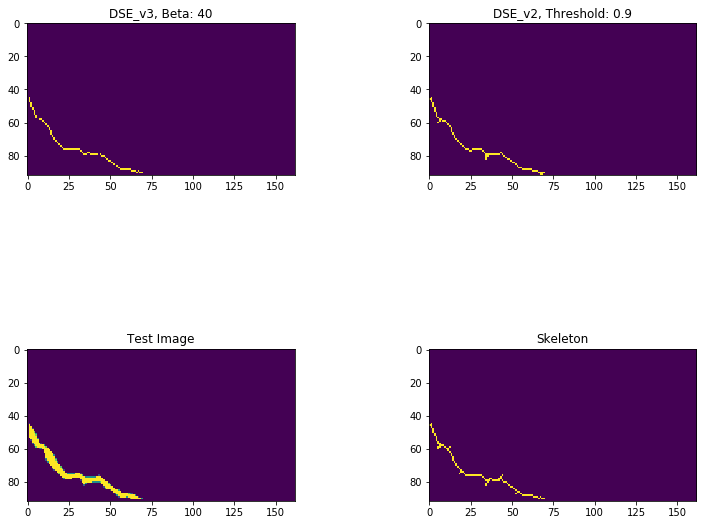

In [22]:
%%time
test_img = x_train_data[11][1]
skeleton = morphology.medial_axis(test_img)
skeleton = morphology.closing(skeleton)
beta = 40
threshold = 0.9 

thin_img,recon_img = DSE_v3(test_img,beta)
t_img,_ = DSE_v2(test_img,threshold)
fig, ax = plt.subplots(nrows = 2, ncols = 2,figsize = (12,12))
plt.subplots_adjust(hspace=0, wspace=0.5)

ax[0][0].imshow(thin_img)
ax[0][0].set_title(f"DSE_v3, Beta: {beta}")
ax[0][1].imshow(t_img)
ax[0][1].set_title(f"DSE_v2, Threshold: {threshold}")
ax[1][0].imshow(test_img)
ax[1][0].set_title("Test Image")
ax[1][1].imshow(skeleton)
ax[1][1].set_title("Skeleton")


The end points: [(2, 11), (140, 25), (31, 32), (150, 35), (161, 36), (74, 40), (120, 49), (128, 68)]
[[(2, 11), (3, 10), (3, 9), (4, 8), (4, 7), (5, 6), (6, 5), (7, 5), (8, 4), (9, 4)], [(140, 25), (141, 26), (141, 27), (142, 28)], [(31, 32), (32, 31), (33, 30), (33, 29)], [(150, 35), (151, 34), (151, 33), (151, 32)], [(161, 36), (160, 35), (159, 34), (158, 33), (157, 32)], [(74, 40), (75, 39), (76, 38)], [(120, 49), (120, 48), (120, 47), (120, 46), (120, 45), (120, 44)], [(128, 68), (129, 69), (130, 70), (130, 71), (131, 72), (131, 73), (132, 74), (132, 75), (133, 76), (134, 77)]]


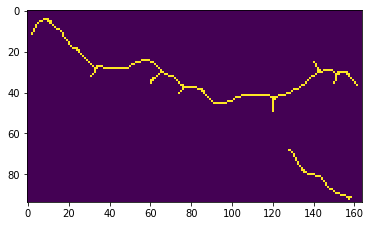

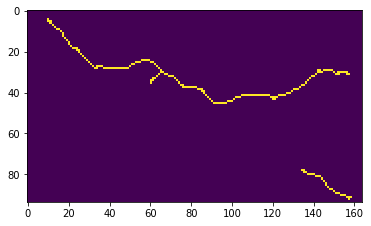

In [23]:
test_img = x_train_data[3][1]
skeleton = morphology.thin(test_img)
skeleton = morphology.closing(skeleton)
skeleton = np.pad(skeleton,((1,1),(1,1)),"constant")
all_branch = get_branches(skeleton)
print(all_branch)
plt.figure()
plt.imshow(skeleton)
for branch in all_branch:    
    for points in branch:
        r = points[1]
        c = points[0]
        skeleton[r,c] = 0
plt.figure()
plt.imshow(skeleton)

# Remove intersection area

In [26]:
def remove_intersection(binary_img,skel_img,dist_trans):
    """
    This function removes the branches from the intersection.
    
    Argument:
    binary_img - Binary image
    skel_img - Pruned skeleton image
    dist_trans - The distance transform matrix of the skeleton image
    
    Return:
    output_img - Individiual branches of the image    
    """
    all_branches = get_branches(skel_img)
    img = skel_img.copy()*1
    for branches in all_branches:
        c,r = branches[-1]
        radius = math.floor(dist_trans[r,c])
        stel = morphology.disk(radius)
        img[r-radius:r+radius+1,c-radius:c+radius+1] -= stel
    
    return img == 1

The end points: [(1, 57), (41, 57), (53, 57), (77, 58), (93, 59), (104, 62), (109, 63), (112, 67), (2, 68), (51, 68), (6, 69), (12, 70), (102, 70), (109, 73), (123, 78), (128, 79), (138, 82), (126, 90), (143, 90)]
The end points: [(1, 57), (41, 57), (53, 57), (77, 58), (93, 59), (104, 62), (109, 63), (112, 67), (2, 68), (51, 68), (6, 69), (12, 70), (102, 70), (109, 73), (123, 78), (128, 79), (138, 82), (126, 90), (143, 90)]


Text(0.5, 1.0, 'Pruned image')

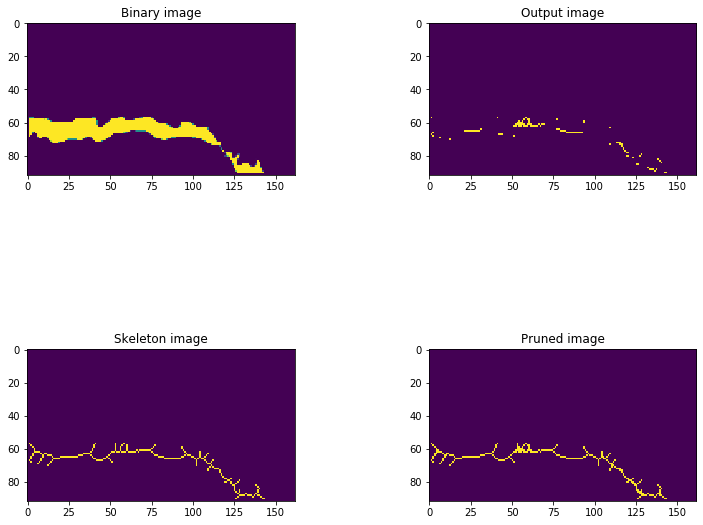

In [27]:
test_img = x_train_data[5][1]
skeleton,dist_tr = morphology.medial_axis(test_img,return_distance=True)
pruned_skel,_ = DSE_v2(skeleton,0.9)
out = remove_intersection(test_img,pruned_skel,dist_tr)
fig, ax = plt.subplots(nrows = 2, ncols = 2,figsize = (12,12))
plt.subplots_adjust(hspace=0, wspace=0.5)

ax[0,0].imshow(test_img)
ax[0,0].set_title("Binary image")
ax[0,1].imshow(out)
ax[0,1].set_title("Output image")
ax[1,0].imshow(skeleton)
ax[1,0].set_title("Skeleton image")
ax[1,1].imshow(pruned_skel)
ax[1,1].set_title("Pruned image")
